In [49]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import gensim
from gensim.models import word2vec
from sklearn.linear_model import LogisticRegression
from statsmodels.discrete.discrete_model import Probit
#from sklearn import metrics
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import pylab #boxplot

import nltk
from nltk.corpus import stopwords
#nltk.download("stopwords")
stop_words =  set(stopwords.words('french'))

random.seed(1)
np.random.seed(1)

### Paramètres généraux

In [50]:
# chemins

os.chdir('C:/Users/torna/Documents/StatApp/StatApp')
#os.chdir('C:/Users/Kim Antunez/Documents/Projets_autres/StatApp')
#os.chdir('/Users/alainquartierlatente/Desktop/Ensae/StatApp')
#os.chdir('/home/aqlt/Documents/Ensae/StatApp')

In [51]:
# pour gensim

nom_dossier = 'ens'
dim = 100
epoch = 100
window = 4
learning_rate = 0.02


In [52]:
# pour les train et test
rm_stopwords = False #True = on enlève les stopwords
lowfrequency_zero_bool= False #true : on met les non reconnus à zero. false : à lowfreq
git = False #True : base git, False : base sncf
logit_bool = True #True : régression logistique, False : probit
########
if rm_stopwords:
    rm_stopwords_string = "rmsw"
else:
    rm_stopwords_string = "nrmsw"
    
#false : on les met à 0 #Rq : le terme est mal choisi, à modifier plus tard
if lowfrequency_zero_bool:
    lowfrequency_zero_string = "z"
else:
    lowfrequency_zero_string = "lf"
    
if git:
    git_string = ""
else:
    git_string = "_sncf"


# Importer le modèle Word2Vec

In [53]:
chemin1 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed1".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:]) 
model1 = gensim.models.keyedvectors.KeyedVectors.load(chemin1 + "/word2vec.model")
chemin2 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed5".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model2 = gensim.models.keyedvectors.KeyedVectors.load(chemin2 + "/word2vec.model")
chemin3 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed10".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model3 = gensim.models.keyedvectors.KeyedVectors.load(chemin3 + "/word2vec.model")
chemin4 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed15".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model4 = gensim.models.keyedvectors.KeyedVectors.load(chemin4 + "/word2vec.model")
chemin5 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed20".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model5 = gensim.models.keyedvectors.KeyedVectors.load(chemin5 + "/word2vec.model")
chemin6 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed25".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:]) 
model6 = gensim.models.keyedvectors.KeyedVectors.load(chemin6 + "/word2vec.model")

In [54]:
matrice = {word : (model1.wv[word]+model2.wv[word]+model3.wv[word]+model4.wv[word]+model5.wv[word]+model6.wv[word])/6
           for word in model1.wv.index2word}

#def normalize(v):
#    norm = np.linalg.norm(v)
#    if norm == 0: 
#        return v
#    return v / norm

#matrice_norm = {word : normalize(matrice[word]) for word in matrice.keys()}

# Fonctions utiles 

In [55]:
def calcul_sentence_embedding(phrase,pond=False,lowfrequency_zero=lowfrequency_zero_bool):
    
    if len(phrase)>0: 
        if(pond): #Modèle de la fin non utilisé
            sum1 = sum(matrice[mot]*matrice_sentiments_val[mot] for mot in phrase if mot in model1.wv.index2word and
                   mot in vocabulaire)
            if lowfrequency_zero==False:
                sum2 = sum(matrice["lowfrequencyword"]*0 for mot in phrase if mot not in model1.wv.index2word)
                return (sum1+sum2)/len(phrase)
            else:
                return  (sum1)/(len([mot for mot in phrase if mot in model1.wv.index2word]))
        else:     
            sum1 = sum(matrice[mot] for mot in phrase if mot in model1.wv.index2word)
            #sum1 = sum(matrice_norm[mot] for mot in phrase if mot in model1.wv.index2word)
            if lowfrequency_zero==False:
                sum2 = sum(matrice["lowfrequencyword"] for mot in phrase if mot not in model1.wv.index2word)
                #sum2 = sum(matrice_norm["lowfrequencyword"] for mot in phrase if mot not in model1.wv.index2word)
                return (sum1+sum2)/len(phrase)
            else:
                taille = len([mot for mot in phrase if mot in model1.wv.index2word])
                if taille>0:
                    return  (sum1)/taille
                else: 
                    return 'NaN'
    else:
        if lowfrequency_zero==False:
            return matrice["lowfrequencyword"]
        else:
            return 'NaN'
#calcul_sentence_embedding(["je","suis","belle"])


In [56]:
def regression_logistique(X_train,Y_train,logit=logit_bool):
    if logit: #logit
        lr = LogisticRegression()
        reg_log = lr.fit(X_train,Y_train)
    else: #probit
        Y_train_prob = [max(val,0) for val in Y_train]
        model = Probit(Y_train_prob, X_train)
        reg_log = model.fit()
    return(reg_log)

In [57]:
def matrice_confusion_accuracy(Y,Y_pred): #X_train, Y_train
    cm = metrics.confusion_matrix(Y,Y_pred)
    print("Matrice de confusion :\n", cm)
    acc = metrics.accuracy_score(Y,Y_pred)
    print("Taux de bien prédits (accuracy) :", acc)
    print("Taux mal prédits : ", 1-(cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1]))
    print("Taux faux positifs : ", 1-cm[0][0]/(cm[0][0]+cm[0][1]))
    print("Taux faux négatifs : ", 1-cm[1][1]/(cm[1][0]+cm[1][1]))


In [58]:
#### new brouillon
#https://albertusk95.github.io/posts/2019/12/best-threshold-maximize-accuracy-from-roc-pr-curve/

def get_seuil(true_label, Y_pred_proba, num_pos_class, num_neg_class):
    pred_proba = Y_pred_proba[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(true_label, pred_proba)
    tp = tpr * num_pos_class
    tn = (1 - fpr) * num_neg_class
    acc = (tp + tn) / (num_pos_class + num_neg_class)
    best_threshold = thresholds[np.argmax(acc)]
    return best_threshold

In [59]:
def courbe_roc(Y,Y_pred): #Y_pred = Y_test_pred #Y = Y_test
    preds = Y_pred[:,1]
    fpr, tpr, threshold = metrics.roc_curve(Y, preds)
    roc_auc = metrics.auc(fpr, tpr)
    
    #intersetion optimale
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    print("intersection optimale : ",list(roc_t['threshold']))

    plt.title('Courbe ROC - Régression logistique')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Taux de vrais positifs')
    plt.xlabel('Taux de faux positifs')
    plt.show()
    #print(roc_auc)

In [60]:
def calcul_AUC(Y,Y_pred,logit=True): #Y_pred = Y_test_pred #Y = Y_test
    if logit:
        preds = Y_pred[:,1]
        fpr, tpr, threshold = metrics.roc_curve(Y, preds)
    else:
        fpr, tpr, threshold = metrics.roc_curve(Y, Y_pred)    
    roc_auc = metrics.auc(fpr, tpr)
    return(roc_auc)

In [61]:
def mots_corpus_absents_dans_word2vec(corpus):
    phrases = [tweet.split() for (score, tweet) in corpus]
    mots = [item for sublist in phrases for item in sublist]
    vocabulaire = list(dict.fromkeys(mots))
    n = 0
    #absents = []
    for word in vocabulaire:
        if word not in model1.wv.index2word:
            n+=1
            #absents.append(word)
    return((n/len(vocabulaire)))

In [62]:
def suppr_stop(phrase):
    return [mot for mot in phrase if mot not in stop_words]

In [63]:
def sentiment_plus(mot, matrice_sentiments):
    plus, moins = matrice_sentiments[mot]
    matrice_sentiments[mot] = (plus+1,moins)
    
def sentiment_moins(mot, matrice_sentiments):
    plus, moins = matrice_sentiments[mot]
    matrice_sentiments[mot] = (plus,moins+1)

def mat_sentiments(corpus_train, vocabulaire):   
    #Initialisation
    matrice_sent = {mot:(0,0) for mot in vocabulaire}
    for (score, tweet) in corpus_train:
        for mot in tweet.split():
            if score == 1:
                sentiment_plus(mot, matrice_sent)
            else:
                sentiment_moins(mot,matrice_sent)
    matrice_sentiments_val = {mot:(matrice_sent[mot][0]-matrice_sent[mot][1])/((matrice_sent[mot][0]+matrice_sent[mot][1]))
                          for mot in vocabulaire}
    return matrice_sentiments_val

Taux de faux positifs = "proportion de négatifs incorrectement prédits" = prédits positifs alors qu'ils étaient négatifs (faux positifs) / négatifs


Taux de faux négatifs = "proportion de positifs incorrectement prédits" = prédits négatifs alors qu'ils étaient positifs (faux négatifs) / positifs


In [64]:
# Créer un DF avec les colonnes suivantes
#Phrases positives 	Phrases négatives 	Phrases positives mal prédites
#Phrases négatives mal prédites 	Pourcentage pos 	Pourcentage neg
def creer_df_mots_pos_neg(phrases_test, phrases_pos_faux, phrases_neg_faux):
    mots = [mot for (tweet,score) in phrases_test for mot in tweet]
    voc_faux = list(dict.fromkeys(mots)) # Tous les mots du voc : ['a', '9h20ascii012ctrlcle',...]
    app_voc = {mot : [0,0,0,0] for mot in voc_faux} #initialisation : {'départ': [0, 0, 0, 0], 'a': [0, 0, 0, 0]....
    for phrase, score in phrases_test:
        for mot in phrase:
            plus, moins,faux_plus,faux_moins = app_voc[mot]
            if score == 1: #si score = 1 on incrémente l'apparition dans les phrases positives
                app_voc[mot] = [plus+1,moins,faux_plus,faux_moins]
            else: #si score = -1 on incrémente l'apparition dans les phrases négatives
                app_voc[mot] = [plus,moins+1,faux_plus,faux_moins]
    for [tweet, proba] in phrases_pos_faux: ## on parcourt les tweets faux positifs ()
        for mot in tweet:
            plus, moins,faux_plus,faux_moins = app_voc[mot]
            app_voc[mot] = [plus,moins,faux_plus+1,faux_moins] #on incrémente chaque mot faux positifs
    for [tweet, proba] in phrases_neg_faux: ## on parcourt les tweets faux négatifs
        for mot in tweet:
            plus, moins,faux_plus,faux_moins = app_voc[mot]
            app_voc[mot] =  [plus,moins,faux_plus,faux_moins+1]  #on incrémente chaque mot faux négatifs
    donnees = [val for val in app_voc.values()]
    mots = [mot for mot in app_voc.keys()]
    df = pd.DataFrame(donnees,index=mots,columns=["Phrases positives","Phrases négatives","Faux positifs","Faux négatifs"])
    df["Nb_occ"] = df["Phrases positives"]+df["Phrases négatives"]
    df["Part Phrases pos SNCF"] = 100 * df["Phrases positives"]/(df["Phrases positives"]+df["Phrases négatives"]) 
    df["Taux de faux positifs"] =100 * df["Faux positifs"]/ df["Phrases négatives"]
    df["Taux de faux négatifs"] =100 * df["Faux négatifs"]/ df["Phrases positives"]
    df["Part Phrases mal préd"] =100 * (df["Faux positifs"]+df["Faux négatifs"])/(df["Phrases négatives"]+ df["Phrases positives"])
    df = df.sort_values(by=['Part Phrases mal préd'],ascending=False)
    df = df.loc[df['Nb_occ'] >= 50]
    df["Proba logit"] = [100 * reg_log.predict_proba([calcul_sentence_embedding([mot])])[0][1] for mot in df.index.values]
    #df = df.loc[ : , ['Nb_occ','Part Phrases mal préd','Part Phrases pos SNCF' ,'Proba logit','Taux de faux positifs','Taux de faux négatifs'] ]
    return df

In [65]:
def nb_mots_PasWord2vec_phrase(phrase):
    compteur = 0
    for mot in phrase:
        if mot not in model1.wv.index2word:
            compteur = compteur + 1
    return compteur

In [66]:
def creer_df_tweets(index=True):
    tweets = []
    score = []
    pred = []
    nb_mots_connus = []
    part_mots_inconnus = []

    # Faux positifs
    for (phrase,chiffre) in phrases_pos_faux:
        nouvelle_phrase = ""
        score += [-1]
        pred += [1]
        for mot in phrase:
            nouvelle_phrase = nouvelle_phrase + " " + str(mot)
        tweets += [nouvelle_phrase]
    for (phrase,inconnus,nbmots) in phrases_pos_faux_compt:
        nb_mots_connus += [nbmots-inconnus]
        if(nbmots>0):
            part_mots_inconnus += [100 * inconnus/nbmots] 
        else:
            part_mots_inconnus += ['NaN'] 
    # Vrais positifs
    for (phrase,chiffre) in phrases_pos_vrai:
        nouvelle_phrase = ""
        score += [1]
        pred += [1]
        for mot in phrase:
            nouvelle_phrase = nouvelle_phrase + " " + str(mot)
        tweets += [nouvelle_phrase]
    for (phrase,inconnus,nbmots) in phrases_pos_vrai_compt:
        nb_mots_connus += [nbmots-inconnus]
        if(nbmots>0):
            part_mots_inconnus += [100 * inconnus/nbmots] 
        else:
            part_mots_inconnus += ['NaN']         
    # Faux negatifs
    for (phrase,chiffre) in phrases_neg_faux:
        nouvelle_phrase = ""
        score += [1]
        pred += [-1]
        for mot in phrase:
            nouvelle_phrase = nouvelle_phrase + " " + str(mot)
        tweets += [nouvelle_phrase]
    for (phrase,inconnus,nbmots) in phrases_neg_faux_compt:
        nb_mots_connus += [nbmots-inconnus]
        if(nbmots>0):
            part_mots_inconnus += [100 * inconnus/nbmots] 
        else:
            part_mots_inconnus += ['NaN'] 
    # Vrais negatifs
    for (phrase,chiffre) in phrases_neg_vrai:
        nouvelle_phrase = ""
        score += [-1]
        pred += [-1]
        for mot in phrase:
            nouvelle_phrase = nouvelle_phrase + " " + str(mot)
        tweets += [nouvelle_phrase]
    for (phrase,inconnus,nbmots) in phrases_neg_vrai_compt:
        nb_mots_connus += [nbmots-inconnus]
        if(nbmots>0):
            part_mots_inconnus += [100 * inconnus/nbmots] 
        else:
            part_mots_inconnus += ['NaN']         
    if index:
        df = pd.DataFrame(list(zip(score, pred,nb_mots_connus,part_mots_inconnus)),
                    index = tweets, columns =['score', 'pred','nb_mots_connus','part_mots_inconnus']
                      ) 
    else:
        df = pd.DataFrame(list(zip(tweets,score, pred,nb_mots_connus,part_mots_inconnus)),
                    columns =['tweet','score', 'pred','nb_mots_connus','part_mots_inconnus']
                      ) 
    return(df)

In [67]:
def restriction(mot):
    res = []
    compt = 0
    for tweet in df_tweets['tweet']:
        compt += 1
        for word in tweet.split():
            if word== mot:
                res += [compt-1]
    return res

In [68]:
def box_plot(df,indicateur="nb_mots_connus"):
    bien_predits = df.loc[((df["score"] == 1) & (df["pred"] == 1)) | ((df["score"] == -1) & (df["pred"] == -1)), indicateur]
    mal_predits = df.loc[((df["score"] == 1) & (df["pred"] == -1)) | ((df["score"] == -1) & (df["pred"] == 1)), indicateur]
    tous = df[indicateur]

    BoxName = ['tweets bien prédits','tweets mal prédits', 'tous les tweets']

    data = [bien_predits,mal_predits, tous]

    plt.ylabel(indicateur)
    plt.boxplot(data)
    pylab.xticks([1,2,3], BoxName)
    plt.show()

# Mots inconnus

In [74]:
with open("data/sentimental_analysis/corpus_test_sncf.file", "rb") as f:
    corpus_test = pickle.load(f)
with open("data/sentimental_analysis/corpus_train_sncf.file", "rb") as f:
    corpus_train = pickle.load(f)
with open("data/sentimental_analysis/corpus_test.file", "rb") as f:
    corpus_test_git = pickle.load(f)

In [79]:
phrases_train = [tweet.split() for (score, tweet) in corpus_train]
mots_train = [item for sublist in phrases_train for item in sublist]
vocabulaire_train = list(dict.fromkeys(mots_train))
phrases_test = [tweet.split() for (score, tweet) in corpus_test]#corpus_test_git si on veut les stats pour base GIT
mots_test = [item for sublist in phrases_test for item in sublist]
vocabulaire_test = list(dict.fromkeys(mots_test))

In [80]:
app_test = {mot:0 for mot in vocabulaire_test}
for phrase in phrases_test:
    for mot in phrase:
        app_test[mot] += 1

In [81]:
compt = 0
compt_mot = 0
for mot in vocabulaire_test:
    find1 = False
    find2 = False
    for word in model1.wv.index2word:
        # Ce qu'on trouve
        if mot == word:
            find1 = True
    for word in vocabulaire_train:
        # Ce qu'on trouve
        if mot == word:
            find2 = True   
    if find1 and find2:     
        compt = compt +1
        compt_mot = compt_mot + app_test[mot]
print(compt)
print(compt_mot)

9809
140018


In [82]:
# Part des mots du voc non en commun
print(100*(len(vocabulaire_test) - compt)/len(vocabulaire_test))
# Part des mots du corpus non en commun
print(100*(len(mots_test) - compt_mot)/len(mots_test))

36.18917512360135
4.672489974877622


# Modèle logistique

In [24]:
# Si on veut récup les fichiers

with open("data/sentimental_analysis/corpus_test{}.file".format(git_string), "rb") as f:
    corpus_test = pickle.load(f)
with open("data/sentimental_analysis/corpus_train{}.file".format(git_string), "rb") as f:
    corpus_train = pickle.load(f)
with open("data/sentimental_analysis/phrasesEmbTest_{}_{}.file".format(rm_stopwords_string,lowfrequency_zero_string), "rb") as f:
    phrases_test_emb = pickle.load(f)
with open("data/sentimental_analysis/phrasesEmbTrain_{}_{}.file".format(rm_stopwords_string,lowfrequency_zero_string), "rb") as f:
    phrases_train_emb = pickle.load(f)

In [25]:
phrases = [tweet.split() for (score, tweet) in corpus_train]
mots = [item for sublist in phrases for item in sublist]
vocabulaire = list(dict.fromkeys(mots))
print("Nombre de mots :", len(mots))
print("Taille du vocabulaire :", len(vocabulaire))

Nombre de mots : 342106
Taille du vocabulaire : 26319


Mots du corpus de train absents du vocabulaire word2vec (en %) 

In [23]:
100 * mots_corpus_absents_dans_word2vec(corpus_train)

39.42019073673012

Mots du corpus de test absents du vocabulaire word2vec (en %) 

In [24]:
100 * mots_corpus_absents_dans_word2vec(corpus_test)

30.477491543065316

données de train

In [26]:
if rm_stopwords:
    phrases = [[suppr_stop(tweet.split()),score] for (score, tweet) in corpus_train]
else:
    phrases = [[tweet.split(),score] for (score, tweet) in corpus_train]
# long à tourner : chargé ci-dessus. 
#phrases_train_emb = [[score,calcul_sentence_embedding(phrase,lowfrequency_zero=lowfrequency_zero_bool)] for (phrase,score) in phrases]
#with open("data/sentimental_analysis/phrasesEmbTrain_{}_{}.file".format(rm_stopwords_string,lowfrequency_zero_string), "wb") as f:
#        pickle.dump(phrases_train_emb, f, pickle.HIGHEST_PROTOCOL)
phrases_train_emb = [[score,phrase] for (score,phrase) in phrases_train_emb if phrase != 'NaN']
Y_train = [score for (score, embedding) in phrases_train_emb]
X_train = [embedding for (score, embedding) in phrases_train_emb]


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


données de test

In [27]:
if rm_stopwords:
    phrases_test = [[suppr_stop(tweet.split()),score] for (score, tweet) in corpus_test]
else:
    phrases_test = [[tweet.split(),score] for (score, tweet) in corpus_test]
# long à tourner : chargé ci-dessus. 
#phrases_test_emb = [[score,calcul_sentence_embedding(phrase,lowfrequency_zero=lowfrequency_zero_bool)] for (phrase,score) in phrases_test]
#with open("data/sentimental_analysis/phrasesEmbTest_{}_{}.file".format(rm_stopwords_string,lowfrequency_zero_string), "wb") as f:
#        pickle.dump(phrases_test_emb, f, pickle.HIGHEST_PROTOCOL)
phrases_test_emb = [[score,phrase] for (score,phrase) in phrases_test_emb if phrase != 'NaN']
Y_test = [score for (score, embedding) in phrases_test_emb]
X_test = [embedding for (score, embedding) in phrases_test_emb]

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


#### Régression logistique (en enlevant les stop_words)

In [39]:
reg_log = regression_logistique(X_train, Y_train, logit = True)
Y_train_proba = reg_log.predict_proba(X_train)
Y_test_proba = reg_log.predict_proba(X_test)

In [40]:
seuil = get_seuil(true_label=Y_test,
          Y_pred_proba=Y_test_proba,
          num_pos_class=len([Y_test for val in Y_test if  val==1]),
          num_neg_class=len([Y_test for val in Y_test if  val==-1])
         )
print(seuil) #proche de 0.5... On laisse à 0.5
seuil = 0.5

0.505072310418019


In [41]:
#Y_train_pred = reg_log.predict(X_train)
Y_train_pred = np.where(Y_train_proba[:,1] > seuil, 1, -1)
#Y_test_pred = reg_log.predict(X_test)
Y_test_pred = np.where(Y_test_proba[:,1] > seuil, 1, -1)

In [42]:
print("TRAIN")
matrice_confusion_accuracy(Y_train,Y_train_pred)
print("\nTEST")
matrice_confusion_accuracy(Y_test,Y_test_pred)

TRAIN
Matrice de confusion :
 [[17577  7423]
 [ 7983 17017]]
Taux de bien prédits (accuracy) : 0.69188
Taux mal prédits :  0.30811999999999995
Taux faux positifs :  0.29691999999999996
Taux faux négatifs :  0.31932000000000005

TEST
Matrice de confusion :
 [[1399  585]
 [ 661 1337]]
Taux de bien prédits (accuracy) : 0.6870919136112507
Taux mal prédits :  0.31290808638874934
Taux faux positifs :  0.2948588709677419
Taux faux négatifs :  0.33083083083083087


Valeur prédite pour lowfrequency ?

In [43]:
if lowfrequency_zero_bool==False:
    lf_pred = reg_log.predict_proba([calcul_sentence_embedding(['lowfrequency'])])[0][1]
    print(lf_pred)

0.7580763866295634


intersection optimale :  [0.4897451799776643]


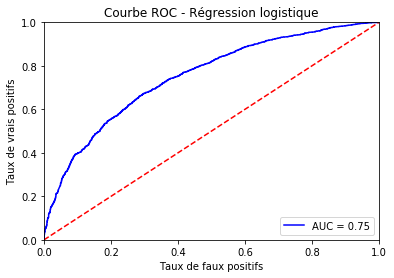

In [41]:
courbe_roc(Y_test,Y_test_proba)

Distribution de proba

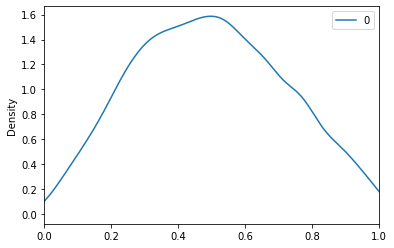

In [42]:
probas = Y_test_proba[:,1]
pd.DataFrame(probas).plot(kind='density',xlim=(0,1)) 

In [168]:
# On sauve les modèles
#with open("data/sentimental_analysis/reg_log_{}_{}{}.file".format(rm_stopwords_string,lowfrequency_zero_string, git_string), "wb") as f:
#        pickle.dump(reg_log, f, pickle.HIGHEST_PROTOCOL)

#### Régression probit (en enlevant les stop_words)

In [34]:
reg_log = regression_logistique(X_train,Y_train,logit=False)
Y_train_pred = reg_log.predict(X_train)
Y_test_pred = reg_log.predict(X_test)

Optimization terminated successfully.
         Current function value: 0.588055
         Iterations 6


In [35]:
print("TRAIN")
matrice_confusion_accuracy(Y_train,[1 if (val >= 0.5) else -1 for val in Y_train_pred])
print("\nTEST")
matrice_confusion_accuracy(Y_test,[1 if (val >= 0.5) else -1 for val in Y_test_pred]) 

TRAIN
Matrice de confusion :
 [[17904  7096]
 [ 8382 16618]]
Taux de bien prédits (accuracy) : 0.69044
Taux mal prédits :  0.30955999999999995
Taux faux positifs :  0.28384
Taux faux négatifs :  0.33528

TEST
Matrice de confusion :
 [[1418  566]
 [ 706 1292]]
Taux de bien prédits (accuracy) : 0.6805625313912607
Taux mal prédits :  0.31943746860873934
Taux faux positifs :  0.2852822580645161
Taux faux négatifs :  0.3533533533533534


Valeur prédite pour lowfrequency ?

In [92]:
if lowfrequency_zero_bool==False:
    lf_pred = reg_log.predict_proba([calcul_sentence_embedding(['lowfrequency'])])[0][1]
    print(lf_pred)

0.7580763866295634


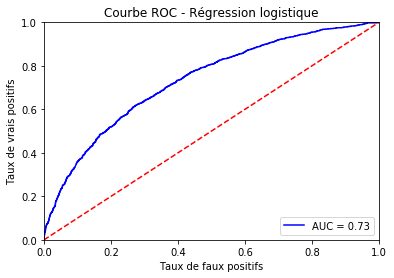

In [225]:
courbe_roc(Y_test,Y_test_proba) #Y_test_proba => logit ??

In [74]:
fpr, tpr, threshold = metrics.roc_curve(Y_test, Y_test_pred)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

0.7325215840840842


Distribution de proba

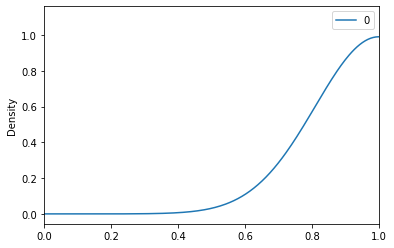

In [120]:
pd.DataFrame(Y_test_pred).plot(kind='density',xlim=(0,1))

In [174]:
# On sauve les modèles
#with open("data/sentimental_analysis/reg_prob_{}_{}{}.file".format(rm_stopwords_string,lowfrequency_zero_string, git_string), "wb") as f:
#        pickle.dump(reg_log, f, pickle.HIGHEST_PROTOCOL)

# Identifier mal prédits

Vu précédemment : 

TEST
Matrice de confusion :

 [[1399  585]
 
 [ 661 1337]]
 
Taux de bien prédits (accuracy) : 0.6870919136112507

Taux mal prédits :  0.31290808638874934

Taux faux positifs :  0.2948588709677419

Taux faux négatifs :  0.33083083083083087

intersection optimale :  [0.4897451799776643]

**Attention** Avant de faire tourner cette partie, faire tourner le dernier type de modèle souhaité ci-dessus (logit ou probit). 

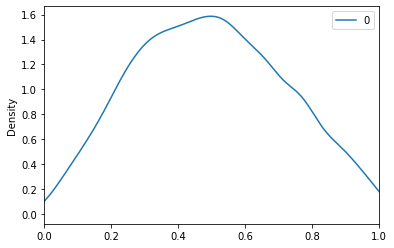

In [43]:
probas = Y_test_proba[:,1]
pd.DataFrame(probas).plot(kind='density',xlim=(0,1)) 

In [44]:
# toutes les phrases
phrases_pred = [(tweet,score,pred,proba) for (tweet,score),pred,proba in zip(phrases_test,Y_test_pred,probas)]
phrases_tot = [[tweet,proba] for (tweet,score,pred,proba) in phrases_pred]
phrases_tot_compt = [[phrase, nb_mots_PasWord2vec_phrase(phrase),len(phrase)] for [phrase,score] in phrases_tot]
#bien prédits positifs 
phrases_pos_vrai = [[tweet,proba] for (tweet,score,pred,proba) in phrases_pred if (score == 1 and pred==1)]
probas_pos_vrai = [proba for [tweet,proba] in phrases_pos_vrai]
phrases_pos_vrai_compt = [[phrase, nb_mots_PasWord2vec_phrase(phrase),len(phrase)] for [phrase,score] in phrases_pos_vrai]
#bien prédits négatifs
phrases_neg_vrai = [[tweet,proba] for (tweet,score,pred,proba) in phrases_pred if (score == -1 and pred==-1)]
probas_neg_vrai = [proba for [tweet,proba] in phrases_neg_vrai]
phrases_neg_vrai_compt = [[phrase, nb_mots_PasWord2vec_phrase(phrase),len(phrase)] for [phrase,score] in phrases_neg_vrai]
#prédits positifs alors qu'ils étaient négatifs (faux positifs)
phrases_pos_faux = [[tweet,proba] for (tweet,score,pred,proba) in phrases_pred if (score == -1 and pred==1)]
probas_pos_faux = [proba for [tweet,proba] in phrases_pos_faux]
phrases_pos_faux_compt = [[phrase, nb_mots_PasWord2vec_phrase(phrase),len(phrase)] for [phrase,score] in phrases_pos_faux]
#prédits négatifs alors qu'ils étaient positifs (faux négatifs)
phrases_neg_faux = [[tweet,proba] for (tweet,score,pred,proba) in phrases_pred if (score == 1 and pred==-1)]
probas_neg_faux = [proba for [tweet,proba] in phrases_neg_faux]
phrases_neg_faux_compt = [[phrase, nb_mots_PasWord2vec_phrase(phrase),len(phrase)] for [phrase,score] in phrases_neg_faux]
# mal prédits
phrases_faux = [[tweet,proba] for (tweet,score,pred,proba) in phrases_pred if ((score == 1 and pred==-1 or (score == -1 and
                                                                                                            pred==1)))]
probas_faux = [proba for [tweet,proba] in phrases_faux]
phrases_faux_compt = [[phrase, nb_mots_PasWord2vec_phrase(phrase),len(phrase)] for [phrase,score] in phrases_faux]

Message : beaucoup de probas autour de 0,5. Distibution unimodale. Montre la difficulté de distringuer vraiment entre phrase négative et phrase positive. 

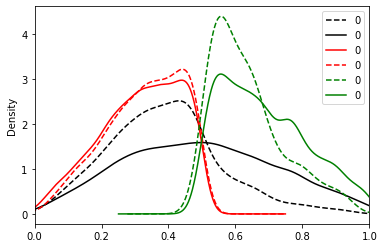

In [45]:
ax = plt.gca()

# probas totale (plein) et probas mal prédits (pointillés)
pd.DataFrame(probas_faux).plot(kind='density',xlim=(0,1),ax=ax,color='black',linestyle='dashed')
pd.DataFrame(probas).plot(kind='density',xlim=(0,1),ax=ax,color='black') 


# Négatifs (plein) et Faux négatifs (pointillés)
pd.DataFrame(probas[probas<seuil]).plot(kind='density',xlim=(0,1),ax=ax,color='red') 
pd.DataFrame(probas_neg_faux).plot(kind='density',xlim=(0,1),ax=ax,color='red',linestyle='dashed')
# Positifs (plein) et Faux positifs (pointillés)
pd.DataFrame(probas_pos_faux).plot(kind='density',xlim=(0,1),ax=ax,color='green',linestyle='dashed')
pd.DataFrame(probas[probas>seuil]).plot(kind='density',xlim=(0,1),ax=ax,color='green') 
plt.show()

Taux de faux positifs = "proportion de négatifs incorrectement prédits" = prédits positifs alors qu'ils étaient négatifs (faux positifs) / négatifs

Taux de faux négatifs = "proportion de positifs incorrectement prédits" = prédits négatifs alors qu'ils étaient positifs (faux négatifs) / positifs


In [46]:
df = creer_df_mots_pos_neg(phrases_test, phrases_pos_faux, phrases_neg_faux)
df
#df.to_csv('mots_mal_predits.csv', sep = ';',encoding='UTF8')

,Phrases positives,Phrases négatives,Faux positifs,Faux négatifs,Nb_occ,Part Phrases pos SNCF,Taux de faux positifs,Taux de faux négatifs,Part Phrases mal préd,Proba logit
espère,64,12,3,37,76,84.210526,25.000000,57.812500,52.631579,54.732030
ptdr,65,7,2,32,72,90.277778,28.571429,49.230769,47.222222,65.709997
cool,53,8,1,26,61,86.885246,12.500000,49.056604,44.262295,99.834795
mettre,34,36,6,22,70,48.571429,16.666667,64.705882,40.000000,79.808946
mdrr,81,11,1,35,92,88.043478,9.090909,43.209877,39.130435,44.216643
...,...,...,...,...,...,...,...,...,...,...
30,15,44,3,3,59,25.423729,6.818182,20.000000,10.169492,71.715092
trafic,24,92,6,5,116,20.689655,6.521739,20.833333,9.482759,49.989754
pire,11,68,2,4,79,13.924051,2.941176,36.363636,7.594937,31.567697
flemme,10,58,2,3,68,14.705882,3.448276,30.000000,7.352941,0.226424


In [47]:
df_tweets = creer_df_tweets(index = False)
df_tweets
#df_tweets.to_csv('df_tweets.csv', sep = ';',encoding='UTF8')

,tweet,score,pred,nb_mots_connus,part_mots_inconnus
0,mahleur 😂😂😂ascii012ctrlcj ai trop la flemme d...,-1,1,26,7.142857
1,jamais je pourrais prendre le bus ou l interc...,-1,1,21,0.000000
2,les ptites pisseuses qui courent pr me devanc...,-1,1,27,3.571429
3,et la mamie qui se plaint qu il y a trop de m...,-1,1,31,0.000000
4,on vient de voir mojito dans le bus et tout c...,-1,1,26,0.000000
...,...,...,...,...,...
3977,si je loupe mon bus à cause de lui je lui fai...,-1,-1,15,0.000000
3978,6 je commence à paniquer je vais rater mon co...,-1,-1,24,4.000000
3979,fr on en parle ou c est comment sans compter ...,-1,-1,21,8.695652
3980,irigol3 avrillé en transat bus déviés rue sch...,-1,-1,15,25.000000


In [48]:
# restriction s'applique que sur df_tweets avec indice = False
df_tweets.iloc[restriction("cool")]#.to_csv("focus_cool.csv",sep = ";", encoding ='UTF8')

,tweet,score,pred,nb_mots_connus,part_mots_inconnus
192,pas très cool les grèves pendant les inondati...,-1,1,24,0.000000
338,si le contrôleur du tgv 5450 pouvait dire aux...,1,1,28,3.448276
379,mais heureusement il y a personne dans mon bu...,1,1,20,4.761905
480,bon en fait rennes ça va être cool je peux fa...,1,1,27,0.000000
559,mais à part ça et les coups de soleil et les ...,1,1,15,0.000000
609,je loupe presque mon bus je me pète la gueule...,1,1,28,0.000000
623,parce qu un métro par minute c est cool mais ...,1,1,24,0.000000
671,vous avez assez manifesté pour vos droit main...,1,1,24,0.000000
750,le cfa es cool ma classe aussi le seul trucs ...,1,1,23,0.000000
834,des bus qui roulent au biocarburant à base de...,1,1,21,4.545455


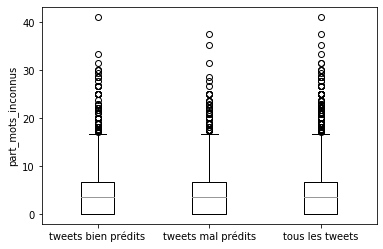

In [49]:
box_plot(df=df_tweets,indicateur="part_mots_inconnus")

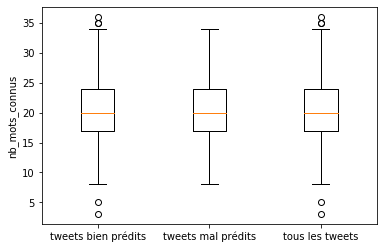

In [50]:
box_plot(df=df_tweets,indicateur="nb_mots_connus")

In [206]:
# pourcentage des mots qui sont dans pas dans word2vec
phrases_tot_pourcent = [[phrase,val1/val2] for [phrase,val1,val2] in phrases_tot_compt if val2>0]
phrases_pos_faux_pourcent = [[phrase,val1/val2] for [phrase,val1,val2] in phrases_pos_faux_compt if val2>0]
phrases_neg_faux_pourcent = [[phrase,val1/val2] for [phrase,val1,val2] in phrases_neg_faux_compt if val2>0]
val_tot_pourcent = [val for [phrase,val] in phrases_tot_pourcent]
val_pos_faux_pourcent = [val for [phrase,val] in phrases_pos_faux_pourcent]
val_neg_faux_pourcent = [val for [phrase,val] in phrases_neg_faux_pourcent]

df_pos = pd.DataFrame(val_pos_faux_pourcent,columns=["val"])
print("Part des phrases contenant au moins 1 mot inconnu à word2vec parmi les faux négatifs",
      round(100 - 100 * df_pos[df_pos["val"]>0].shape[0] / df_pos.shape[0],0))

df_neg = pd.DataFrame(val_neg_faux_pourcent,columns=["val"])
print("Part des phrases contenant au moins 1 mot inconnu à word2vec parmi les faux positifs",
      round(100 - 100 * df_neg[df_neg["val"]>0].shape[0] / df_neg.shape[0],0))

df_tot = pd.DataFrame(val_tot_pourcent,columns=["val"])
print("Part des phrases contenant au moins 1 mot inconnu à word2vec parmi toutes les phrases",
      round(100 - 100 * df_tot[df_tot["val"]>0].shape[0] / df_tot.shape[0],0))

Part des phrases contenant au moins 1 mot inconnu à word2vec parmi les faux négatifs 52.0
Part des phrases contenant au moins 1 mot inconnu à word2vec parmi les faux positifs 43.0
Part des phrases contenant au moins 1 mot inconnu à word2vec parmi toutes les phrases 48.0


### Mots de la base test inconnus dans word2vec

In [53]:
with open('data/%s/vocabulary.file' %nom_dossier, "rb") as f:
    vocabulaire_word2vec = pickle.load(f) 
fdist_word2vec = nltk.FreqDist(vocabulaire_word2vec)

phrases_test = [tweet.split() for (score, tweet) in corpus_test]
mots_test = [item for sublist in phrases_test for item in sublist]
vocabulaire_test = list(dict.fromkeys(mots_test))
fdist_test = nltk.FreqDist(mots_test)


In [91]:
temp = [w for w, index in fdist_word2vec.items()]
vocabulaire_test_word2vec = [[w,index] for w, index in fdist_test.items() if w in temp ]

In [92]:
# Part des mots du voc non en commun
print(100 - 100*(len(vocabulaire_test_word2vec)/len(vocabulaire_test)))

30.477491543065312


In [93]:
# Part des mots du corpus non en commun
print(100 - 100*(sum([index for w, index in vocabulaire_test_word2vec])/sum([index for w, index in fdist_test.items()])))

4.036601057999334


# Sélection du meilleur modèle

In [23]:
def calculate_aic(n, mse, num_params = 100):
    aic = n * log(mse) + 2 * num_params
    return aic

def calculate_bic(n, mse, num_params = 100):
    bic = n * log(mse) + num_params * log(n)
    return bic

In [24]:
import random
from random import sample
from sklearn.metrics import mean_squared_error
from math import log

def selection_regression():
    for git_string in [True,False]:
        print("Données GIT : ", git_string)
        for logit_bool in [True,False]:
            print("Logit ? : ", logit_bool)
            for rm_stopwords_string in ["rmsw","nrmsw"]:
                print("Stopwords ? : ", rm_stopwords_string)
                for lowfrequency_zero_string in ["z","lf"]:
                    print("Lowfrequency : ", lowfrequency_zero_string)
                    if git_string:
                        with open("data/sentimental_analysis/phrasesEmbTest_{}_{}.file".format(rm_stopwords_string,
                                                                                                  lowfrequency_zero_string
                                                                                              ), "rb") as f:
                            phrases_test_emb = pickle.load(f)
                        with open("data/sentimental_analysis/phrasesEmbTrain_{}_{}.file".format(rm_stopwords_string,
                                                                                                  lowfrequency_zero_string
                                                                                              ), "rb") as f:
                            phrases_train_emb = pickle.load(f)
                    else:
                        with open("data/sentimental_analysis/phrasesEmbTest_{}_{}_sncf.file".format(rm_stopwords_string,
                                                                                                  lowfrequency_zero_string
                                                                                              ), "rb") as f:
                            phrases_test_emb = pickle.load(f)
                        with open("data/sentimental_analysis/phrasesEmbTrain_{}_{}_sncf.file".format(rm_stopwords_string,
                                                                                                  lowfrequency_zero_string
                                                                                              ), "rb") as f:
                            phrases_train_emb = pickle.load(f)
                    phrases_train_emb = [[score,phrase] for (score,phrase) in phrases_train_emb if phrase != 'NaN']
                    Y_train = [score for (score, embedding) in phrases_train_emb]
                    X_train = [embedding for (score, embedding) in phrases_train_emb]
                    reg_log = regression_logistique(X_train,Y_train,logit=logit_bool)
                    if logit_bool:
                            Y0 = reg_log.predict(X_train)
                    else:
                            Y_train_pred = reg_log.predict(X_train)
                            Y0 = [1 if (val >= 0.5) else -1 for val in Y_train_pred]
                    n = len(phrases_train_emb)
                    mse = mean_squared_error(Y_train, Y0)
                    print("AIC : ", calculate_aic(n, mse), " - BIC : ", calculate_bic(n, mse))
                    phrases_test_emb = [[score,phrase] for (score,phrase) in phrases_test_emb if phrase != 'NaN']
                    random.seed(1)
                    for i in range(5):
                        phrases_test_emb_1 = sample(phrases_test_emb,round(0.8*len(phrases_test_emb)))
                        Y_test = [score for (score, embedding) in phrases_test_emb_1]
                        X_test = [embedding for (score, embedding) in phrases_test_emb_1]
                        if logit_bool:
                            Y_test_pred = reg_log.predict_proba(X_test)
                            Y1 = reg_log.predict(X_test)
                        else:
                            Y_test_pred = reg_log.predict(X_test)
                            Y1 = [1 if (val >= 0.5) else -1 for val in Y_test_pred]
                        print("Test ", i," : ",calcul_AUC(Y_test,Y_test_pred,logit_bool))

In [25]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
selection_regression()

Données GIT :  True
Logit ? :  True
Stopwords ? :  rmsw
Lowfrequency :  z
AIC :  12856.279453439765  - BIC :  13737.223961466814
Test  0  :  0.7315647938505668
Test  1  :  0.7286790567626477
Test  2  :  0.7348735609215259
Test  3  :  0.7406654693069818
Test  4  :  0.7228329754360237
Lowfrequency :  lf
AIC :  13102.363366104511  - BIC :  13984.34119454554
Test  0  :  0.738426714974151
Test  1  :  0.7371667783858296
Test  2  :  0.7335052066420548
Test  3  :  0.7316336068700485
Test  4  :  0.729781364232016
Stopwords ? :  nrmsw
Lowfrequency :  z
AIC :  10498.827769210402  - BIC :  11380.006412658475
Test  0  :  0.7430967067853483
Test  1  :  0.7497856107221161
Test  2  :  0.7511024820010319
Test  3  :  0.7434914022450453
Test  4  :  0.7530581537504432
Lowfrequency :  lf
AIC :  10651.419981125931  - BIC :  11533.397809566959
Test  0  :  0.7547773850671078
Test  1  :  0.7548189972229808
Test  2  :  0.7505771364887402
Test  3  :  0.7466513951633497
Test  4  :  0.7479022198575271
Logit ? :  F

In [26]:
def selection_regression_croisee():#Changement par rapport au précédent = bases de test, on teste les modèles GIT sur
    # données SNCF et modèles SNCF sur données GIT
    for git_string in [True,False]:
        print("Données GIT : ", git_string)
        for logit_bool in [True,False]:
            print("Logit ? : ", logit_bool)
            for rm_stopwords_string in ["rmsw","nrmsw"]:
                print("Stopwords ? : ", rm_stopwords_string)
                for lowfrequency_zero_string in ["z","lf"]:
                    print("Lowfrequency : ", lowfrequency_zero_string)
                    if git_string:# Changement ici dans le chargement des bases tests
                        with open("data/sentimental_analysis/phrasesEmbTest_{}_{}_sncf.file".format(rm_stopwords_string,
                                                                                                  lowfrequency_zero_string
                                                                                              ), "rb") as f:
                            phrases_test_emb = pickle.load(f)
                        with open("data/sentimental_analysis/phrasesEmbTrain_{}_{}.file".format(rm_stopwords_string,
                                                                                                  lowfrequency_zero_string
                                                                                              ), "rb") as f:
                            phrases_train_emb = pickle.load(f)
                    else:
                        with open("data/sentimental_analysis/phrasesEmbTest_{}_{}.file".format(rm_stopwords_string,
                                                                                                  lowfrequency_zero_string
                                                                                              ), "rb") as f:
                            phrases_test_emb = pickle.load(f)
                        with open("data/sentimental_analysis/phrasesEmbTrain_{}_{}_sncf.file".format(rm_stopwords_string,
                                                                                                  lowfrequency_zero_string
                                                                                              ), "rb") as f:
                            phrases_train_emb = pickle.load(f)
                    phrases_train_emb = [[score,phrase] for (score,phrase) in phrases_train_emb if phrase != 'NaN']
                    Y_train = [score for (score, embedding) in phrases_train_emb]
                    X_train = [embedding for (score, embedding) in phrases_train_emb]
                    reg_log = regression_logistique(X_train,Y_train,logit=logit_bool)
                    if logit_bool:
                            Y0 = reg_log.predict(X_train)
                    else:
                            Y_train_pred = reg_log.predict(X_train)
                            Y0 = [1 if (val >= 0.5) else -1 for val in Y_train_pred]
                    n = len(phrases_train_emb)
                    mse = mean_squared_error(Y_train, Y0)
                    print("AIC : ", calculate_aic(n, mse), " - BIC : ", calculate_bic(n, mse))
                    phrases_test_emb = [[score,phrase] for (score,phrase) in phrases_test_emb if phrase != 'NaN']
                    random.seed(1)
                    for i in range(5):
                        phrases_test_emb_1 = sample(phrases_test_emb,round(0.8*len(phrases_test_emb)))
                        Y_test = [score for (score, embedding) in phrases_test_emb_1]
                        X_test = [embedding for (score, embedding) in phrases_test_emb_1]
                        if logit_bool:
                            Y_test_pred = reg_log.predict_proba(X_test)
                            Y1 = reg_log.predict(X_test)
                        else:
                            Y_test_pred = reg_log.predict(X_test)
                            Y1 = [1 if (val >= 0.5) else -1 for val in Y_test_pred]
                        print("Test ", i," : ",calcul_AUC(Y_test,Y_test_pred,logit_bool))

In [ ]:
selection_regression_croisee()

Données GIT :  True
Logit ? :  True
Stopwords ? :  rmsw
Lowfrequency :  z
AIC :  12856.279453439765  - BIC :  13737.223961466814
Test  0  :  0.6774684639867647
Test  1  :  0.6892085575905977
Test  2  :  0.6839088660578386
Test  3  :  0.6794753081401461
Test  4  :  0.6805471326677224
Lowfrequency :  lf
AIC :  13102.363366104511  - BIC :  13984.34119454554
Test  0  :  0.6748411839029294
Test  1  :  0.6857030955489224
Test  2  :  0.6794611600347902
Test  3  :  0.6768759938474945
Test  4  :  0.6778293324219622
Stopwords ? :  nrmsw
Lowfrequency :  z
AIC :  10498.827769210402  - BIC :  11380.006412658475
Test  0  :  0.669531712736722
Test  1  :  0.6756839940026772
Test  2  :  0.6717689986953685
Test  3  :  0.6690692438683606
Test  4  :  0.6712388843370176
Lowfrequency :  lf
AIC :  10651.419981125931  - BIC :  11533.397809566959
Test  0  :  0.6677892763861315
Test  1  :  0.6739830577944463
Test  2  :  0.6689157969123722
Test  3  :  0.6679926096226658
Test  4  :  0.6699510831301304
Logit ? :  